Import libraries

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, kruskal


Load data

In [24]:
def load_and_label_data(file_path: str, country_name: str) -> pd.DataFrame:
    """
    Loads a CSV file and adds a 'Country' column to identify the data source.

    Parameters:
    -----------
    file_path : str
        Path to the CSV file containing cleaned solar data.
    country_name : str
        Name of the country to assign in the 'Country' column.

    Returns:
    --------
    pd.DataFrame
        A pandas DataFrame containing the loaded data with a 'Country' column added.
    """
    df = pd.read_csv(file_path)
    df['Country'] = country_name
    return df

def combine_datasets(dfs: list) -> pd.DataFrame:
    """
    Combines multiple DataFrames into a single DataFrame.

    Parameters:
    -----------
    dfs : list of pd.DataFrame
        A list of DataFrames to concatenate.

    Returns:
    --------
    pd.DataFrame
        A single concatenated DataFrame.
    """
    return pd.concat(dfs, ignore_index=True)

# === Load and label individual datasets === #
df_benin = load_and_label_data("data/benin_clean.csv", "Benin")
df_sierra = load_and_label_data("data/sierraleone_clean.csv", "Sierra Leone")
df_togo = load_and_label_data("data/togo_clean.csv", "Togo")

# === Combine all datasets into one === #
df_all = combine_datasets([df_benin, df_sierra, df_togo])


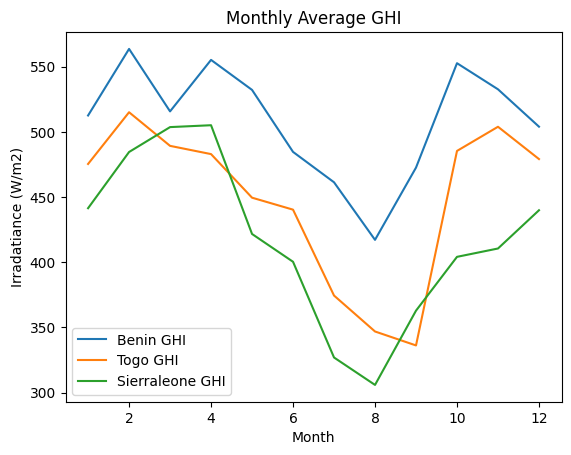

In [27]:
df_benin['Timestamp'] = pd.to_datetime(df_benin['Timestamp'])
df_benin = df_benin[(df_benin['GHI'] >= 0) & (df_benin['DNI'] >= 0) & (df_benin['DHI'] >=0 )]
df_benin['month'] = df_benin['Timestamp'].dt.month
benin_monthly = df_benin.groupby('month')[['GHI','DNI','DHI']].mean()
benin_monthly['GHI'].plot(label='Benin GHI')

df_togo['Timestamp'] = pd.to_datetime(df_togo['Timestamp'])
df_togo = df_togo[(df_togo['GHI'] >= 0) & (df_togo['DNI'] >= 0) & (df_togo['DHI'] >=0 )]
df_togo['month'] = df_togo['Timestamp'].dt.month
togo_monthly = df_togo.groupby('month')[['GHI','DNI','DHI']].mean()
togo_monthly['GHI'].plot(label='Togo GHI')

df_sierra['Timestamp'] = pd.to_datetime(df_sierra['Timestamp'])
df_sierra = df_sierra[(df_sierra['GHI'] >= 0) & (df_sierra['DNI'] >= 0) & (df_sierra['DHI'] >=0 )]
df_sierra['month'] = df_sierra['Timestamp'].dt.month
sierra_monthly = df_sierra.groupby('month')[['GHI','DNI','DHI']].mean()
sierra_monthly['GHI'].plot(label='Sierraleone GHI')
plt.legend()
plt.title('Monthly Average GHI')
plt.xlabel('Month')
plt.ylabel('Irradatiance (W/m2)')
plt.show()

Metric Comparison

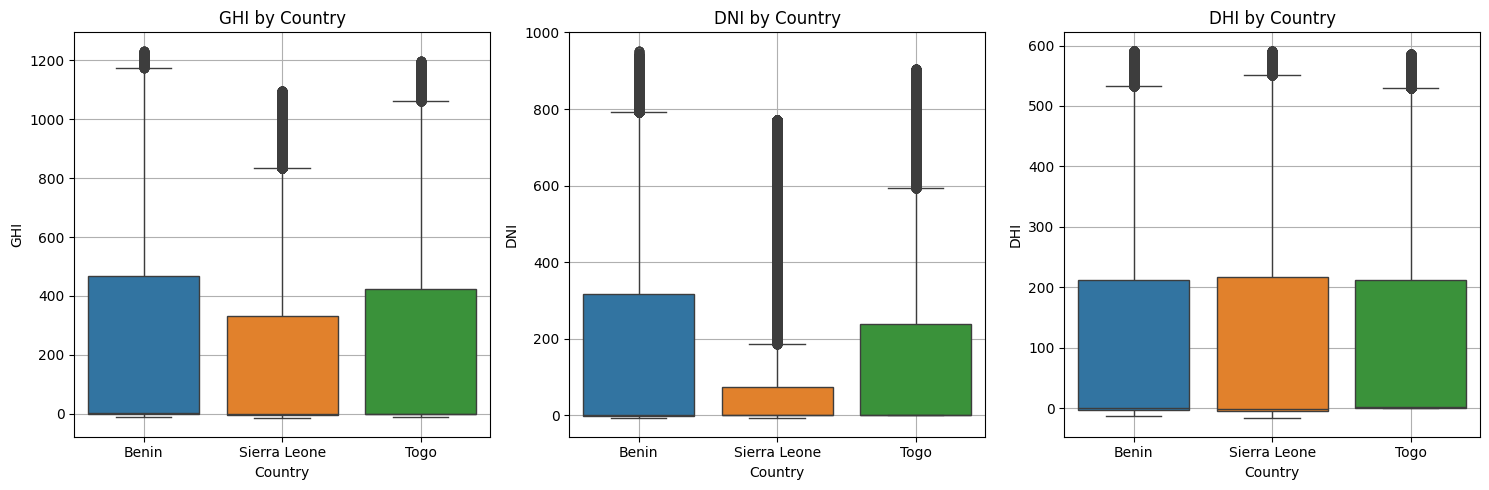

In [ ]:
def plot_irradiance_boxplots(df: pd.DataFrame, metrics: list, palette: dict) -> None:
    """
    Plots side-by-side boxplots for each specified solar irradiance metric by country.

    Parameters:
    -----------
    df : pd.DataFrame
        The combined DataFrame that contains the irradiance metrics and country labels.
    
    metrics : list
        List of column names (e.g., ['GHI', 'DNI', 'DHI']) representing solar measurements.
    
    palette : dict
        Dictionary mapping each country to a custom color (e.g., {'Benin': '#1f77b4'}).

    Returns:
    --------
    None
        Displays a matplotlib figure with boxplots.
    """
    plt.figure(figsize=(5 * len(metrics), 5))  # Dynamically scale width

    for i, metric in enumerate(metrics):
        plt.subplot(1, len(metrics), i + 1)
        sns.boxplot(
            x='Country',
            y=metric,
            hue='Country',
            data=df,
            palette=palette,
            legend=False
        )
        plt.title(f'{metric} by Country')
        plt.ylabel(metric)
        plt.grid(True)

    plt.tight_layout()
    plt.show()


# === Define palette and metrics === #
custom_palette = {
    'Benin': '#1f77b4',          # blue
    'Sierra Leone': '#ff7f0e',   # orange
    'Togo': '#2ca02c'            # green
}
metrics = ['GHI', 'DNI', 'DHI']

# === Call the function to visualize === #
plot_irradiance_boxplots(df_all, metrics, custom_palette)


Summary Statistics & Missing-Value Report

In [ ]:
def summarize_irradiance_metrics(df: pd.DataFrame, metrics: list) -> pd.DataFrame:
    """
    Computes descriptive statistics (mean, median, std) for specified irradiance metrics grouped by country.

    Parameters:
    -----------
    df : pd.DataFrame
        Combined dataset that includes irradiance metrics and country labels.

    metrics : list
        List of columns (e.g., ['GHI', 'DNI', 'DHI']) to summarize.

    Returns:
    --------
    pd.DataFrame
        A summary DataFrame containing mean, median, and standard deviation for each metric by country.
    """
    # Compute group-level stats
    summary = df.groupby('Country')[metrics].agg(['mean', 'median', 'std'])
    
    # Flatten MultiIndex columns (e.g., ('GHI', 'mean') → 'GHI_mean')
    summary.columns = [f"{metric}_{stat}" for metric, stat in summary.columns]
    
    # Reset index to make 'Country' a column
    summary.reset_index(inplace=True)

    return summary


# === Call the function === #
metrics = ['GHI', 'DNI', 'DHI']
summary_df = summarize_irradiance_metrics(df_all, metrics)

# === Display neatly === #
print("📊 Solar Irradiance Summary by Country (Mean, Median, Std):\n")
print(summary_df.to_string(index=False))


📊 Solar Irradiance Summary by Country (Mean, Median, Std):

     Country   GHI_mean  GHI_median    GHI_std   DNI_mean  DNI_median    DNI_std   DHI_mean  DHI_median    DHI_std
       Benin 236.234508         0.7 328.288787 166.896673        -0.1 262.081997 111.656477         0.5 153.099749
Sierra Leone 185.000024        -0.4 279.019460 104.128943        -0.1 200.954182 108.104278        -0.6 153.691835
        Togo 223.859675         0.5 317.306277 147.975931         0.0 247.683690 112.781249         1.5 151.571744


In [ ]:
def perform_anova_for_metric(df: pd.DataFrame, metric: str, country_col: str = 'Country') -> float:
    """
    Performs a one-way ANOVA test to compare the given metric across different countries.

    Parameters:
    -----------
    df : pd.DataFrame
        Combined DataFrame that includes the metric and country column.
    
    metric : str
        The name of the metric column (e.g., 'GHI') to test.
    
    country_col : str
        The name of the column that holds country labels. Default is 'Country'.

    Returns:
    --------
    float
        The p-value of the ANOVA test indicating whether the differences across groups are statistically significant.
    """
    # Separate data by country
    grouped_data = [group[metric].dropna() for _, group in df.groupby(country_col)]

    # Perform ANOVA
    anova_result = f_oneway(*grouped_data)
    
    return anova_result.pvalue


# === Run the test for GHI === #
ghi_pvalue = perform_anova_for_metric(df_all, 'GHI')

# === Output === #
print("📈 One-way ANOVA Test for GHI across countries")
print(f"🔍 p-value: {ghi_pvalue:.5f}")

# Optional interpretation for beginners
if ghi_pvalue < 0.05:
    print("✅ Result: Statistically significant difference in GHI between countries.")
else:
    print("❌ Result: No statistically significant difference in GHI between countries.")


📈 One-way ANOVA Test for GHI across countries
🔍 p-value: 0.00000
✅ Result: Statistically significant difference in GHI between countries.


In [ ]:
def perform_anova_for_metric(df: pd.DataFrame, metric: str, country_col: str = 'Country') -> float:
    """
    Performs a one-way ANOVA test to compare the given metric across different countries.

    Parameters:
    -----------
    df : pd.DataFrame
        Combined DataFrame that includes the metric and country column.
    
    metric : str
        The name of the metric column (e.g., 'GHI') to test.
    
    country_col : str
        The name of the column that holds country labels. Default is 'Country'.

    Returns:
    --------
    float
        The p-value of the ANOVA test indicating whether the differences across groups are statistically significant.
    """
    # Separate data by country
    grouped_data = [group[metric].dropna() for _, group in df.groupby(country_col)]

    # Perform ANOVA
    anova_result = f_oneway(*grouped_data)
    
    return anova_result.pvalue


# === Run the test for GHI === #
ghi_pvalue = perform_anova_for_metric(df_all, 'GHI')

# === Output === #
print("📈 One-way ANOVA Test for GHI across countries")
print(f"🔍 p-value: {ghi_pvalue:.5f}")

# Optional interpretation for beginners
if ghi_pvalue < 0.05:
    print("✅ Result: Statistically significant difference in GHI between countries.")
else:
    print("❌ Result: No statistically significant difference in GHI between countries.")


📈 One-way ANOVA Test for GHI across countries
🔍 p-value: 0.00000
✅ Result: Statistically significant difference in GHI between countries.


### 🔍 Key Observations

- **Benin** has the **highest average GHI (236.2)** and **DNI (166.9)**, suggesting it receives more solar radiation on average than Togo and Sierra Leone. However, it also has the **highest variability in GHI (std = 328.3)** and **DNI (std = 262.1)**, indicating **large fluctuations** in solar irradiance.

- **Sierra Leone** shows the **lowest mean GHI (185.0)** and **DNI (104.1)**, with a **median below zero**, indicating frequent periods with **little or no direct solar radiation**. This may be due to more cloud cover or weather-related conditions.

- **Togo** presents a **balance between Benin and Sierra Leone**, with a **moderate GHI mean (223.9)** and **median slightly positive (0.5)**. It also has the **highest median DHI (1.5)**, suggesting relatively **stable diffuse solar radiation**.


# Visual Summary

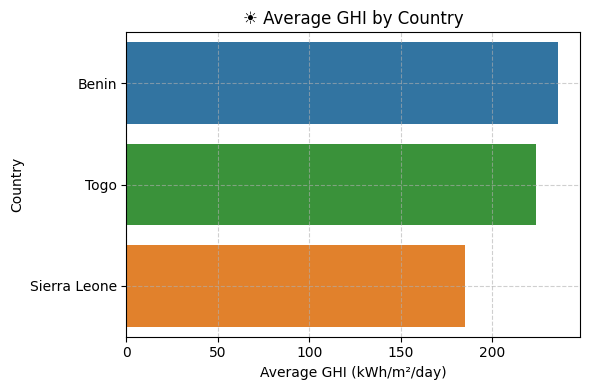

In [ ]:
# Define custom color palette
CUSTOM_PALETTE = {
    'Benin': '#1f77b4',          # blue
    'Sierra Leone': '#ff7f0e',   # orange
    'Togo': '#2ca02c'            # green
}

def plot_avg_ghi_bar_chart(df: pd.DataFrame, country_col: str = 'Country', ghi_col: str = 'GHI', palette: dict = CUSTOM_PALETTE):
    """
    Plots a horizontal bar chart showing the average Global Horizontal Irradiance (GHI) per country.

    Parameters:
    -----------
    df : pd.DataFrame
        The combined DataFrame containing the GHI values and country information.

    country_col : str
        Column name representing countries. Default is 'Country'.

    ghi_col : str
        Column name representing GHI values. Default is 'GHI'.

    palette : dict
        Custom color palette mapping countries to colors.
    """

    # Compute average GHI per country
    avg_ghi = df.groupby(country_col)[ghi_col].mean().sort_values(ascending=False)
    avg_ghi_df = avg_ghi.reset_index()

    # Plotting
    plt.figure(figsize=(6, 4))
    sns.barplot(
        x=ghi_col,
        y=country_col,
        data=avg_ghi_df,
        hue=country_col,
        palette=palette,
        dodge=False,
        legend=False
    )

    plt.xlabel("Average GHI (kWh/m²/day)")
    plt.title("☀️ Average GHI by Country")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


# === Call the function === #
plot_avg_ghi_bar_chart(df_all)
